            Timestamp  Price
Timestamp                   
1991-01-02 1991-01-02  15.63
1991-01-03 1991-01-03  15.39
1991-01-04 1991-01-04  15.31
1991-01-07 1991-01-07  15.47
1991-01-09 1991-01-09  15.31
                Price
Timestamp            
1991-01-31  14.055333
1991-02-28  15.044615
1991-03-31  14.127143
1991-04-30  10.632857
1991-05-31   8.754091
...               ...
2020-03-31  28.338182
2020-04-30  26.600476
2020-05-31  25.858889
2020-06-30  26.154500
2020-07-31  29.064615

[355 rows x 1 columns]


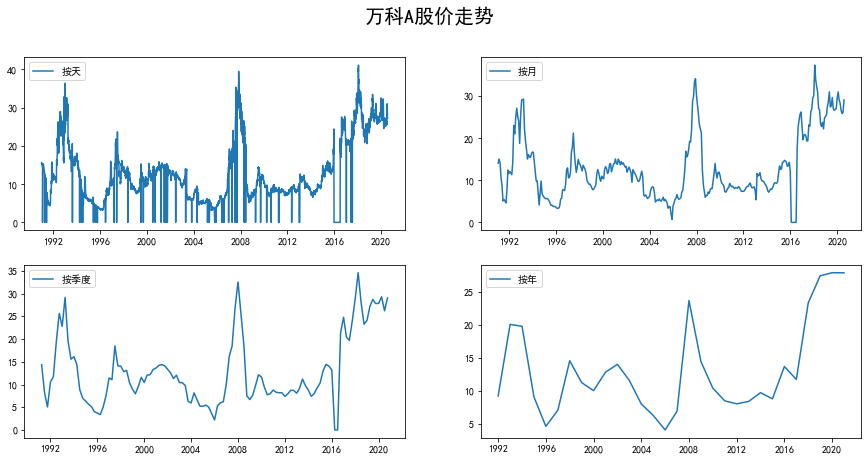

参数错误: (0, 2)
参数错误: (2, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  355
Model:                     ARMA(2, 0)   Log Likelihood                -765.350
Method:                       css-mle   S.D. of innovations              2.082
Date:                Fri, 17 Jul 2020   AIC                           1538.701
Time:                        22:27:20   BIC                           1554.189
Sample:                    01-31-1991   HQIC                          1544.862
                         - 07-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.6428      2.347      5.813      0.000       9.043      18.243
ar.L1.Price     1.1843      0.052     22.904      0.000       1.083       1.286
ar.L2.Price    

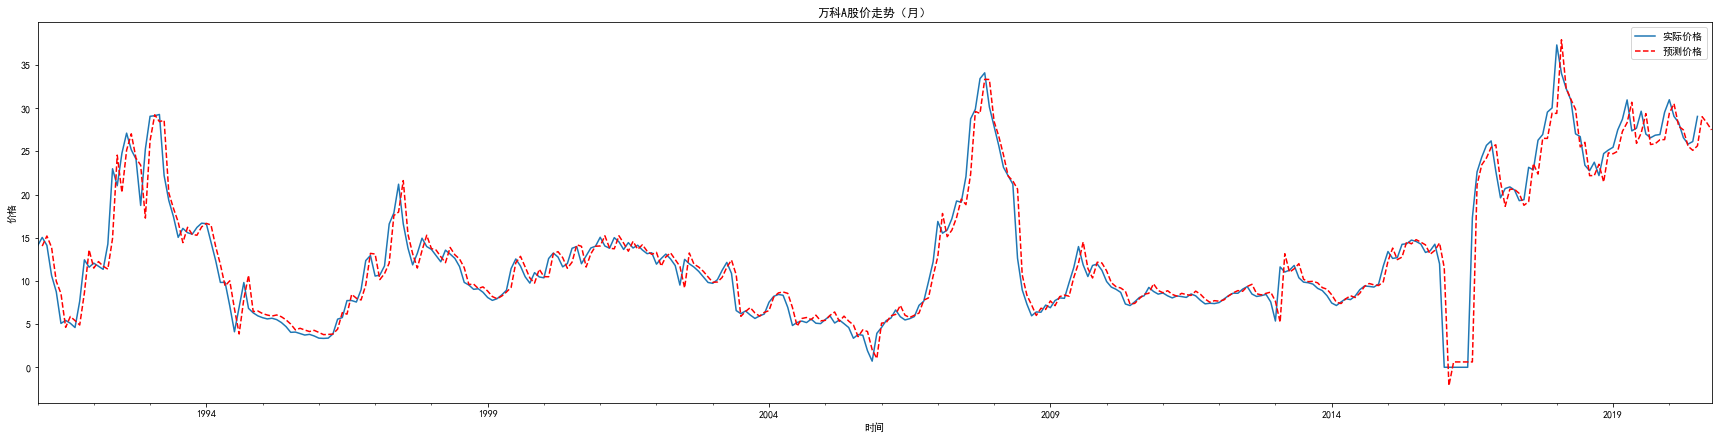

In [5]:
# -*- coding: utf-8 -*-
# 沪市指数走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_csv('./wk000002.csv')
df = df[['Timestamp', 'Price']]

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)
#print(df_Q)
#print(df_year)

# 按照天，月，季度，年来显示股票价格的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('万科A股价走势', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
print(df_month2)

# 股票价格预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际价格')
df_month2.forecast.plot(color='r', ls='--', label='预测价格')
plt.legend()
plt.title('万科A股价走势（月）')
plt.xlabel('时间')
plt.ylabel('价格')
plt.show()
